In [ ]:
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from PIL import Image
from utils import visualization_utils as vis_util

In [2]:
%matplotlib inline

# Vars

In [3]:
PATH_TO_CKPT = os.path.join('fine_tuned_model_rcnn100', 'frozen_inference_graph.pb') 
PATH_TO_LABELS = os.path.join('data', 'FullIJCNN_label_map.pbtxt')
NUM_CLASSES = 43
PATH_TO_TEST_IMAGES_DIR = 'data/test_images'
my_test_images = os.listdir(PATH_TO_TEST_IMAGES_DIR)
IMAGE_SIZE = (12, 8) # Size, in inches, of the output images.


# Loading model

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loading labels 

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Helper code

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detect 1 image

In [7]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

# Detect images from list

In [8]:
def detect_and_show_images(path_test_images, test_images):
    for image_name in test_images:
      image = Image.open(path_test_images + "/" + image_name)
      print(path_test_images + "/" + image_name)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)
      print(output_dict)
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Detection

data/test_images/00524.jpg
{'num_detections': 300, 'detection_boxes': array([[8.1765456e-03, 0.0000000e+00, 6.0337469e-02, 1.2745067e-02],
       [6.3160248e-02, 3.0951614e-02, 6.3978845e-01, 3.1165224e-01],
       [8.8869332e-04, 0.0000000e+00, 5.8257464e-02, 1.4781094e-02],
       ...,
       [1.0625763e-02, 2.6486861e-03, 1.4310989e-01, 2.5231093e-02],
       [7.0017405e-02, 2.1538103e-04, 1.6702506e-01, 1.8653017e-02],
       [8.4206715e-02, 1.0171246e-02, 1.5411612e-01, 6.8850622e-02]],
      dtype=float32), 'detection_scores': array([7.7697341e-06, 6.1788874e-06, 6.1055762e-06, 5.0323874e-06,
       4.6011023e-06, 4.5303304e-06, 4.1578637e-06, 3.6898020e-06,
       3.6392460e-06, 3.5285702e-06, 3.3487111e-06, 3.2974262e-06,
       3.2517298e-06, 3.2405480e-06, 3.2060007e-06, 3.1213337e-06,
       3.1139359e-06, 3.0447820e-06, 3.0064120e-06, 2.9977889e-06,
       2.8785582e-06, 2.7657013e-06, 2.7000269e-06, 2.6921973e-06,
       2.5094348e-06, 2.4526485e-06, 2.4120093e-06, 2.36309

{'num_detections': 300, 'detection_boxes': array([[0.0074496 , 0.        , 0.05983984, 0.01290634],
       [0.        , 0.        , 0.05900222, 0.01494844],
       [0.08368538, 0.03003377, 0.6559694 , 0.3134226 ],
       ...,
       [0.        , 0.        , 0.05267613, 0.01635997],
       [0.01391943, 0.        , 0.09721952, 0.01585232],
       [0.        , 0.04309718, 0.04771885, 0.09002624]], dtype=float32), 'detection_scores': array([1.1774142e-05, 7.9694419e-06, 7.2560611e-06, 7.1471618e-06,
       6.6179923e-06, 6.1980218e-06, 5.9293488e-06, 5.5819087e-06,
       5.5652836e-06, 5.2353362e-06, 5.0686622e-06, 4.8484440e-06,
       4.8367588e-06, 4.8239135e-06, 4.6900946e-06, 4.6484447e-06,
       4.6406822e-06, 4.4477711e-06, 4.4013323e-06, 4.2378610e-06,
       4.1837429e-06, 4.1689323e-06, 4.0335663e-06, 4.0085329e-06,
       3.8877465e-06, 3.8563553e-06, 3.7845984e-06, 3.5780131e-06,
       3.5740463e-06, 3.5446201e-06, 3.5251576e-06, 3.5091696e-06,
       3.4216353e-06, 3.373591

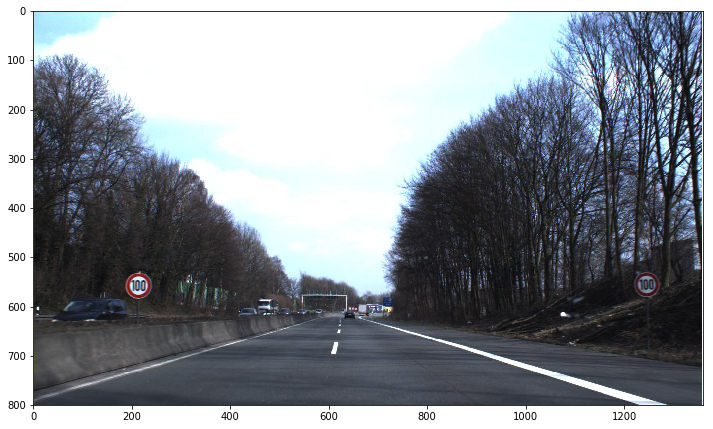

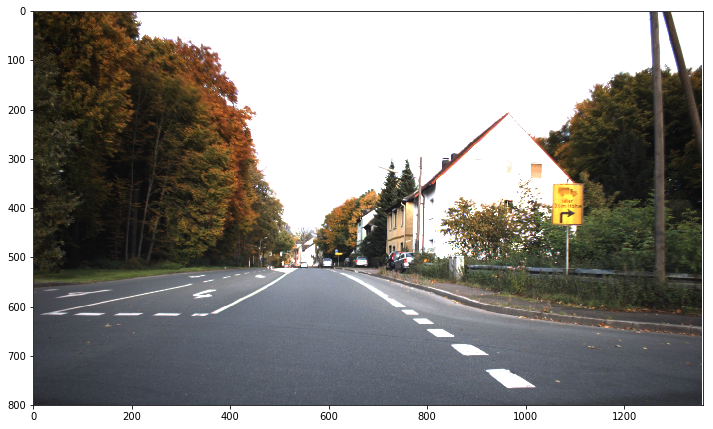

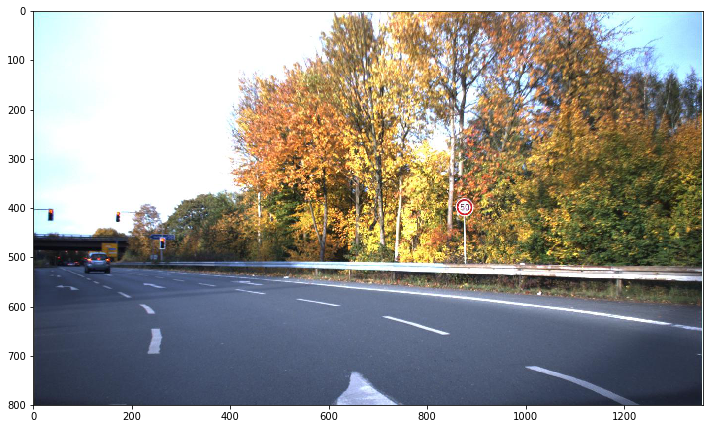

In [9]:
detect_and_show_images(PATH_TO_TEST_IMAGES_DIR, my_test_images)